# A Hybrid Learning Approach to Synthetic Position Construction for Tax Loss Harvesting

# Generation of Synthetic Positions Using Hybrid Learning

In [1]:
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
import statsmodels.api as sm
import operator
from deprecated import deprecated

corr_matrix_file_path = "pickles/corr_matrix.obj"
x_labels_file_path = "pickles/X_labels.obj"
sptm_comp_file_path = "pickles/sptm_composition.obj"
sptm_price_file_path = "pickles/sptm_price.obj"

In [2]:
# Composition data from pickle
sptm_comp_file = open(sptm_comp_file_path, 'rb')
sptm_composition = pickle.load(sptm_comp_file)
sptm_comp_file.close()

# Price history downloaded from Yahoo Finance and stored in pickle
sptm_price_file = open(sptm_price_file_path, 'rb')
sptm_price_history = pickle.load(sptm_price_file)
sptm_price_file.close()

all_tickers = sptm_composition.keys()

# Gets a list of all valid trading dates
all_dates = sptm_price_history[list(all_tickers)[0]].axes[0].values
dates = pd.DatetimeIndex(data=all_dates)
current_date = all_dates[0]

# 80/20 Test/Train Split
# Data Range: 2015-01-02 - 2020-08-10
# Testing Range: 2020-08-11 - 2021-12-31
train_start_date = 0
train_end_date = 1410
test_start_date = 1411
test_end_date = 1762

# Choose how many days should be used to validate the hyperparameters
num_validation_days = 30

### Finding Highly Correlated Stocks
#### Use the *do_corr_matrix_regen* variable to tell the code to generate the correlation matrix, else it will load it from a pickle

In [3]:
num_stocks = len(all_tickers)


@deprecated(reason="Switched to generating singular correlation lists on the fly")
def regenerate_corr_matrix(end_date, recent_days):
    """Calculates the correlation between every stock's percent time series
    :param end_date: The last date for which data should be used to generate the correlation matrix
    :param recent_days: How many days of price history should be used to calculate the correlation matrix
    """
    x_vars = []
    x_labels = []

    for ticker in all_tickers:
        x_vars.append(sptm_price_history[ticker].Close.pct_change().iloc[end_date - recent_days:end_date])
        x_labels.append(ticker)

    correlation_matrix = [[0 for _ in range(0, num_stocks)] for _ in range(0, num_stocks)]

    for l in range(0, num_stocks):
        for m in range(0, num_stocks):
            correlation_matrix[l][m] = x_vars[l].corr(x_vars[m])
    correlation_matrix = pd.DataFrame(correlation_matrix, columns=x_labels[0:num_stocks])

    correlation_matrix_file = open(corr_matrix_file_path, 'wb')
    pickle.dump(correlation_matrix, correlation_matrix_file)
    correlation_matrix_file.close()

    x_labels_file = open(x_labels_file_path, 'wb')
    pickle.dump(x_labels, x_labels_file)
    x_labels_file.close()


@deprecated(reason="Switched to generating singular correlation lists on the fly")
def load_corr_matrix():
    """Loads correlation matrix and labels from pickles
    :returns: [correlation_matrix, x_labels]
    """
    # Covariance Matrix from pickle
    corr_matrix_file = open(corr_matrix_file_path, 'rb')
    correlation_matrix = pickle.load(corr_matrix_file)
    corr_matrix_file.close()

    # X_Labels from pickle
    x_labels_file = open(x_labels_file_path, 'rb')
    x_labels = pickle.load(x_labels_file)
    x_labels_file.close()

    return correlation_matrix, x_labels


def corr_list_for_single_stock(ticker, end_date, recent_days):
    x_labels = []

    ticker_price_history = sptm_price_history[ticker].Close.pct_change().iloc[end_date - recent_days:end_date]

    for tickers in sptm_price_history.keys():
        x_labels.append(tickers)

    correlation_matrix = {}

    for l in range(0, len(x_labels)):
        correlation_matrix[x_labels[l]] = ticker_price_history.corr(
            sptm_price_history[x_labels[l]].Close.pct_change().iloc[end_date - recent_days:end_date])
    correlation_matrix = dict(sorted(correlation_matrix.items(), key=operator.itemgetter(1), reverse=True))

    return correlation_matrix


In [4]:
def filter_substantially_similar_securities(ticker, series, additional_stocks=None):
    """Filters out the stocks you cannot buy because of a wash sale
    :param series: The series of correlated stocks that should be filtered
    :param ticker: Ticker to filter out securities for
    :param additional_stocks: Any additional stocks you want to filter out (default = None)
    """
    if additional_stocks is None:
        additional_stocks = []

    # Handles Google having both GOOG and GOOGL in the dataset
    if ticker == "GOOG" or ticker:
        additional_stocks.append("GOOG")
        additional_stocks.append("GOOGL")

    additional_stocks.append(ticker)

    for remove_stock in additional_stocks:
        # for r_stock in remove_stock:
        if remove_stock in series:
            series.pop(series.index(remove_stock))

    return series


def find_top_correlated_stocks(correlation_list, ticker, n):
    """Finds the top n stocks correlated with a given stock
    :param correlation_list: The correlation list to get the top correlated stocks from
    :param n: the number of correlated stocks to return
    :param ticker: The ticker for which correlated stocks should be found
    :returns: A list (sorted by most correlation) of correlated stocks
    """

    filtered_correlations = filter_substantially_similar_securities(ticker, list(correlation_list.keys()))

    return filtered_correlations[:n]

### Principle Component Analysis

In [5]:
def get_price_histories_dataframe(stocks, target_stock, end_date, recent_days):
    """Compiles a DataFrame with the price histories of the specified stocks
    :param target_stock: The stock for which the dataset should be created
    :param stocks: The stocks to include in the DataFrame
    :param end_date: The last date for which data should be used to get the price history
    :param recent_days: How many days of price history should be fetched
    :returns: (Features DataFrame, Target DataFrame)"""
    d = {}
    for correlated_stock in stocks:
        d[correlated_stock] = sptm_price_history[correlated_stock].Close.values[end_date - recent_days:end_date]
    target = pd.DataFrame(
        {target_stock: sptm_price_history[target_stock].Close.values[end_date - recent_days:end_date]})
    return pd.DataFrame(data=d), target


def get_datasets(correlation_list, target_stock, n, end_date, recent_days):
    """Compiles the necessary datasets for PCA. One with the price history of the features, and one with the price history of the target
    :param correlation_list: The correlation list to get the top correlated stocks from
    :param target_stock: The stock for which the dataset should be created
    :param n: the number of datasets to get
    :param end_date: The last date for which data should be used to get the price history
    :param recent_days: How many days of price history should be fetched
    :returns: (x, y) where x and y are DataFrames
    """
    corr_stocks = find_top_correlated_stocks(correlation_list, target_stock, n)
    return get_price_histories_dataframe(corr_stocks, target_stock, end_date, recent_days)

In [6]:
def predict_portfolio(pred_stock, n_components, n_days, end_date, n_stocks, is_sparse):
    """Constructs a portfolio using the given hyperparameters
    :param pred_stock: The stock to predict
    :param n_components: The number of principal components the model should use
    :param n_days: The number of days of data the model should consider
    :param end_date: The last date of data the model should use
    :param n_stocks: The number of stocks to be used by principal component analysis
    :param is_sparse: Whether PCA should be sparse or not
    """
    correlation_list = corr_list_for_single_stock(pred_stock, end_date, n_days)

    # Get price history datasets
    x, y = get_datasets(correlation_list, pred_stock, n_stocks, end_date, n_days)

    # Standardize the features
    X = StandardScaler().fit_transform(x)

    # Do the PCA
    if is_sparse:
        pca = SparsePCA(n_components=n_components)
    else:
        pca = PCA(n_components=n_components)

    principal_components = pca.fit_transform(X)
    principal_df = pd.DataFrame(data=principal_components, columns=["PC " + str(g) for g in range(0, n_components)])

    # Linear Regression of principal components
    model = sm.OLS(principal_df, y).fit()

    loadings = pd.DataFrame(pca.components_.T, index=x.columns)
    loadings_dict = {stock: [] for stock in loadings[0].index.values}

    for c_stock in loadings[0].index.values:
        for pc in range(0, n_components):
            loadings_dict[c_stock].append(loadings[pc][c_stock])

    synthetic_position = {}
    if n_components==1:
        for c_stock in loadings_dict.keys():
            synthetic_position[c_stock] = loadings_dict[c_stock][0]
        return synthetic_position

    for c_stock in loadings_dict.keys():
        quantity = 0
        for pc in range(0, n_components):
            quantity += model.params[pc][pred_stock] * loadings_dict[c_stock][pc]
        synthetic_position[c_stock] = quantity
    return synthetic_position

In [7]:
def hybrid_learning_replace(ticker) -> {}:
    """Determines which stocks to buy to emulate the performance of another
    :param ticker: The stock for which a synthetic position should be calculated
    :returns: Dictionary of replacement tickers and their quantities
    """
    print(ticker)
    return {}
    #TODO

# Stock Market Backtester

If you want to run this simulator with different stocks and/or generate a new starting portfolio, do the following:
1. Create a CSV file with the format: Ticker, Quantity
2. Run **csvToComp.py** to generate text you can paste in as the *snp_composition* variable in **compToPickle.py**
3. Run **compToPickle.py**
4. Adjust the date range in **yfToPickle.py**
5. Run **yfToPickle.py**, which will take a while, since it is downloading all of the price histories from Yahoo Finance

In [8]:
import pandas as pd
# import pyfolio as pf  #install using  pip3 install git+https://github.com/quantopian/pyfolio
from enum import Enum
import warnings
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random
%matplotlib inline

snp_comp_file_path = "pickles/snp_composition.obj"
snp_price_file_path = "pickles/snp_price.obj"

In [9]:
# Composition data from pickle
snp_comp_file = open(snp_comp_file_path, 'rb')
snp_composition = pickle.load(snp_comp_file)
snp_comp_file.close()

# Price history downloaded from Yahoo Finance and stored in pickle
snp_price_file = open(sptm_price_file_path, 'rb')
price_history = pickle.load(snp_price_file)
snp_price_file.close()



# Gets a list of all valid trading dates
all_dates = price_history[list(all_tickers)[0]].axes[0].values
dates = pd.DatetimeIndex(data=all_dates)

In [10]:
def get_stock_price(ticker, day, time) -> float:
    """Retrieves the closing price of a stock on a given date
    :param ticker: stock for which to retrieve the value
    :param day: date on which to retrieve the value
    :param time of day to calculate the value, either Time.OPEN or Time.CLOSE
    """
    if time == Time.OPEN:
        return round(price_history[ticker].Open[day], 2)
    elif time == Time.CLOSE:
        return round(price_history[ticker].Close[day], 2)


class Time(Enum):
    OPEN = 0
    CLOSE = 1


class Stock:
    def __init__(self, ticker, cur_date, q=0):
        """Creates an object representing an owned stock
        :param ticker: The stock's ticker symbol
        :param q: How much of this stock is owned (this should only be used when constructing initial stock portfolios, as it essentially creates stock for free)
        """
        self.ticker = ticker
        self.quantity = q
        self.avg_cost = get_stock_price(self.ticker, cur_date, Time.OPEN)

    def buy(self, quantity, day_price):
        """Simulates a portfolio acquiring new stock
        :param quantity: The amount of new stock to acquire
        :param day_price: The price of the stock on the day of acquisition
        """
        previously_owned = self.quantity
        self.quantity += quantity
        self.avg_cost += (previously_owned * self.avg_cost + quantity * day_price) / self.quantity

    def sell(self, q, day_price):
        """Simulates a portfolio selling a stock
        :param q: The amount of new stock to sell
        :param day_price: The price of the stock on the day of acquisition
        """
        previously_owned = self.quantity
        self.quantity -= q
        self.avg_cost -= (previously_owned * self.avg_cost - q * day_price) / self.quantity

    def sell_all(self):
        """Simulates selling all of a stock
        """
        self.quantity = 0
        self.avg_cost = 0

    def get_pct_change(self, change_date):
        """Gets the percent change of the stock based on the average cost
        """
        change = self.get_change(change_date)
        return 100 * (change / self.avg_cost)

    def get_change(self, change_date) -> float:
        """Gets the difference between the stock's average purchase price and its current price
        :returns: float
        """
        current_price = get_stock_price(self.ticker, change_date, Time.OPEN)
        return current_price - self.avg_cost


class Portfolio:
    def __init__(self, name, sim_start_date, starting_cash_balance: float = 1000000, starting_stocks=None,
                 baseline=False, synthetic=False):
        """Creates a new portfolio
        :param starting_cash_balance: The amount of cash the portfolio should start with (default 100,000.0)
        :param starting_stocks: A dictionary containing the stocks the portfolio should begin with {'Ticker': Stock Object} (default is no starting stocks)
        """
        self.name = name
        if starting_stocks is None:
            starting_stocks = {}
        self.stocks = starting_stocks
        self.cash_balance = starting_cash_balance
        self.value = 0
        self.calculate_value(Time.OPEN, sim_start_date)
        self.price_history = {}
        self.closing_prices = []
        self.returns = None
        self.wash_sale_list = {}
        self.baseline = baseline
        self.synthetic = synthetic
        self.diff = []

    def calculate_value(self, time, calc_date):
        """Calculates the value of the portfolio based on the close of the global current date
        :param calc_date: The date on whcih to calculate the value
        :param time of day to calculate the value, either Time.OPEN or Time.CLOSE
        """
        self.calculate_value_date(calc_date, time)

    def calculate_value_date(self, c_day, time=Time.OPEN):
        """Calculates the value of the portfolio based on a specified date
        :param c_day: the date on which the portfolio's value should be calculated
        :param time of day to calculate the value, either Time.OPEN or (default) Time.CLOSE
        """

        self.value = self.cash_balance
        for stock in self.stocks.keys():
            self.value += get_stock_price(stock, c_day, time) * self.stocks[stock].quantity

        return self.value

    def update_wash_sale_list(self):
        """Increments the counter for every item in the wash sale list and removes an item if the counter is >30
        """
        remove_from_list = []
        for wash_stock in self.wash_sale_list.keys():
            self.wash_sale_list[wash_stock] += 1
            if self.wash_sale_list[wash_stock] > 30:
                remove_from_list.append(wash_stock)

        for to_remove in remove_from_list:
            self.wash_sale_list.pop(to_remove)

    def begin_day(self, date_to_begin):
        """Calculates the starting value of the day and updates the wash sale list
        """
        self.calculate_value(Time.OPEN, date_to_begin)
        self.update_wash_sale_list()

    def end_day(self, date_to_record):
        """"Calculates the day's closing value and adds it to a list
        :param date_to_record: The date associated with the ending day
        """
        self.calculate_value(Time.OPEN, date_to_record)
        self.price_history[date_to_record] = self.value
        self.closing_prices.append(self.value)

    def end_simulation(self, start_date_index, end_date_index):
        """Creates a Pandas Series of percent change of closing values and returns it
        :param start_date_index: The index of the day that the simulation started
        :param end_date_index: The index of the day that the simulation ended
        """
        self.returns = pd.Series(data=self.closing_prices, index=dates[start_date_index:end_date_index]).pct_change()
        return self.returns

    def does_own_stock(self, ticker) -> bool:
        """Reports whether this portfolio contains a given stock
        :param ticker: The stock to search for
        """
        return ticker in self.stocks.keys()

    def buy_stock(self, ticker, buy_date, quantity_to_buy):
        """Buys stock using cash balance if possible
        :param buy_date: The date on which to buy the stocks
        :param ticker: The stock to purchase
        :param quantity_to_buy: The quantity of the stock to purchase (can be a float)
        """
        stock_price = get_stock_price(ticker, buy_date, Time.OPEN)
        trade_basis = stock_price * quantity_to_buy  #TODO can add fees here

        # Exit if we cannot complete the trade
        if trade_basis > self.cash_balance:
            warnings.warn("Not enough cash to execute trade: buy " + str(quantity_to_buy) + " " + ticker)
            return

        if ticker in self.wash_sale_list:
            warnings.warn("Cannot buy " + ticker + ": wash sale violation")
            return

        # If we do not currently own the stock, create an entry
        if ticker not in self.stocks.keys():
            self.stocks[ticker] = Stock(ticker, buy_date)

        # Execute the trade
        self.stocks[ticker].buy(quantity_to_buy, stock_price)
        self.cash_balance -= trade_basis

    def sell_stock(self, ticker, sell_date, sell_quantity=0, sell_all=False):
        """Sells stock and adds to cash balance
        :param sell_date: The date on which to sell the stocks
        :param ticker: The stock to sell
        :param sell_quantity: The quantity of the stock to sell (can be a float)
        :param sell_all: Optional parameter to sell all stock
        """
        stock_price = get_stock_price(ticker, sell_date, Time.OPEN)
        # Ensure we have enough stock to sell
        quantity_owned = self.stocks[ticker].sell_quantity
        if sell_quantity > quantity_owned:
            return

        if sell_all or sell_quantity == quantity_owned:
            self.stocks[ticker].sell_all()
            self.cash_balance += quantity_owned * stock_price
            self.stocks.pop(ticker)

            # Update the wash sale list
            self.wash_sale_list[ticker] = 0
            return

        # Do the trade
        self.stocks[ticker].sell()
        self.cash_balance += sell_quantity * stock_price  #TODO maybe things should be added to the wash sale list even if we just sell partial (but in theory we are always doing sellall)

    def identify_losers(self, loser_date):
        """Identifies stocks that have dropped in value more than 5% since they were bought
        :returns: List of all stocks that have dropped more than 5%
        """
        identified_losers = []
        for owned_stock in self.stocks.keys():
            if self.stocks[owned_stock].get_change(loser_date) <= -1 * (0.05 * self.value):
                identified_losers.append(owned_stock)
        return identified_losers

    def calculate_diff(self, baseline):
        for m in range(0, len(self.closing_prices)):
            self.diff.append(self.closing_prices[m] - baseline[m])

def scale_portfolio_value(p, ratio, s_s_date):
    """Returns a new portfolio with quantities of each stock scaled by a specified ratio"""
    new_p = {}
    for s in p.stocks:
        new_p[s] = Stock(s, s_s_date, p.stocks[s].quantity*ratio)

    is_baseline = p.baseline
    is_synthetic = p.synthetic
    new_port = Portfolio(p.name, s_s_date, p.cash_balance, new_p, baseline=is_baseline, synthetic=is_synthetic)

    return new_port


def get_normalized_portfolios(p, s_s_date):
    """Accepts portfolios and returns new portfolios with the same value on the start date
    Limitations: All portfolios but the synthetic one can only contain one stock
    :param p: The portfolios to normalize (the baseline must be in position 1 and the synthetic portfolio must be marked)
    :param s_s_date: The start date on which to normalize the portfolios
    """
    return_ports = []

    for port in p:
        port_value = port.calculate_value_date(s_s_date)
        ratio = 100 / port_value

        new_port = scale_portfolio_value(port, ratio, s_s_date)

        return_ports.append(new_port)

    return return_ports


def plot_portfolio(p, sim_end_date, sim_start_date):
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=round((sim_end_date - sim_start_date) / 10)))

    for port in p:
        days = []
        y_price = []
        for price in port.price_history:
            days.append(price)
            y_price.append(port.price_history[price])
        plt.plot(days, y_price, label=port.name)

    plt.gcf().autofmt_xdate()
    plt.rcParams["figure.figsize"] = [16, 9]
    plt.legend(loc='best')
    # x1,x2,y1,y2 = plt.axis()
    # plt.axis((x1,x2,0,200))
    plt.show()


def plot_differences(p, sim_end_date, sim_start_date):
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=round((sim_end_date - sim_start_date) / 10)))

    for port in p:
        days = []
        for price in port.price_history:
            days.append(price)
        plt.plot(days, port.diff, label=port.name)
    plt.gcf().autofmt_xdate()
    plt.rcParams["figure.figsize"] = [16, 9]
    plt.legend(loc='best')
    plt.show()

def get_correlations(portfolios):
    correlations = {}
    for p in portfolios:
        if p.baseline:
            for po in portfolios:
                if not po.baseline:
                    correlations[p.name+"x"+po.name] = po.returns.corr(p.returns)
        return correlations


def print_correlations(portfolios):
    correlations = get_correlations(portfolios)
    for correlation in correlations.keys():
        print(correlation+": "+str(correlations[correlation]))


def generate_end_report(portfolios, sim_start_date, sim_end_date):
    plot_portfolio(portfolios, sim_end_date, sim_start_date)
    for p in portfolios:
        p.calculate_diff(portfolios[0].closing_prices)
    plot_differences(portfolios, sim_end_date, sim_start_date)
    # print_correlations(portfolios)

def get_stats(portfolios):
    correlations = get_correlations(portfolios)

    mse = {}
    for p in portfolios:
        p.calculate_diff(portfolios[0].closing_prices)
    for p in portfolios:
        squared_diff = [val**2 for val in p.diff]
        mse[p.name] = sum(squared_diff)/len(squared_diff)
        if not p.baseline and not p.synthetic:
            mse["CORR"] = sum(squared_diff)/len(squared_diff)

    mse_percent = {}
    baseline = portfolios[0].returns[1:].values
    for p in portfolios:
        pct_changes = p.returns[1:].values
        diff = [pct_changes[h]*100 - baseline[h]*100 for h in range(0, len(pct_changes))]
        squared_diff = [val**2 for val in diff]
        mse_percent[p.name] = sum(squared_diff)/len(squared_diff)

    return {"Correlation": correlations, "MSE": mse, "MSE_percent":mse_percent}

In [27]:
def model_output_to_portfolio(model_output, output_date):
    p = {}
    for a_stock in model_output.keys():
        p[a_stock] = Stock(a_stock, output_date, model_output[a_stock])
    return p


def run_simulation(sim_start_date, sim_end_date, portfolios, graph = True):
    # Run the simulation
    for date in range(sim_start_date, sim_end_date):
        # Allow the portfolio to perform start of day updates
        for sim_portfolio in portfolios:
            sim_portfolio.begin_day(date)

            # Determine which stocks should be tax loss harvested
            # losers = sim_portfolio.identify_losers(date)

            # for losing_stock in losers:
            #     # Get dictionary of replacement stocks {'Ticker': Quantity}
            #     replacement_stocks = hybrid_learning_replace(losing_stock)
            #
            #     # Sell the losing stock
            #     portfolio.sell_stock(losing_stock, sell_all=True)
            #
            #     # Buy the replacement stocks
            #     for buy_stock in replacement_stocks.keys():
            #         portfolio.buy_stock(buy_stock, replacement_stocks[buy_stock])

            # Allow the portfolio to perform end-of-day updates
            sim_portfolio.end_day(all_dates[date])

    returns = []

    # Inform the portfolio that the simulation has ended
    for portfolio in portfolios:
        returns.append(portfolio.end_simulation(sim_start_date, sim_end_date))

    if graph:
        generate_end_report(portfolios, sim_start_date, sim_end_date)


def simulate_stock(stock, sim_start_date, sim_end_date, tra_end_date, train_num_days, num_principal_components,
                   num_pred_stocks, is_sparse, graph = True):
    # Find correlated stock during training period
    correlated_stock_ticker = list(corr_list_for_single_stock(stock, tra_end_date, train_num_days).keys())[1]

    # Find synthetic stock portfolio during training period
    synth_stocks = model_output_to_portfolio(
        predict_portfolio(stock, num_principal_components, train_num_days, tra_end_date, num_pred_stocks, is_sparse),
        sim_start_date)

    synth_stock_portfolio = Portfolio("Synthetic", sim_start_date, 0, starting_stocks=synth_stocks, synthetic=True)
    correlated_stock_portfolio = Portfolio(correlated_stock_ticker, sim_start_date, 0, starting_stocks={
        correlated_stock_ticker: Stock(correlated_stock_ticker, sim_start_date, 1)})
    baseline_stock_portfolio = Portfolio(stock, sim_start_date, 0,
                                         starting_stocks={stock: Stock(stock, sim_start_date, 1)}, baseline=True)

    # ensure that the real stock is first in the portfolio
    portfolios = get_normalized_portfolios(
        [baseline_stock_portfolio, synth_stock_portfolio, correlated_stock_portfolio], sim_start_date)
    run_simulation(sim_start_date, sim_end_date, portfolios, graph)
    return get_stats(portfolios)

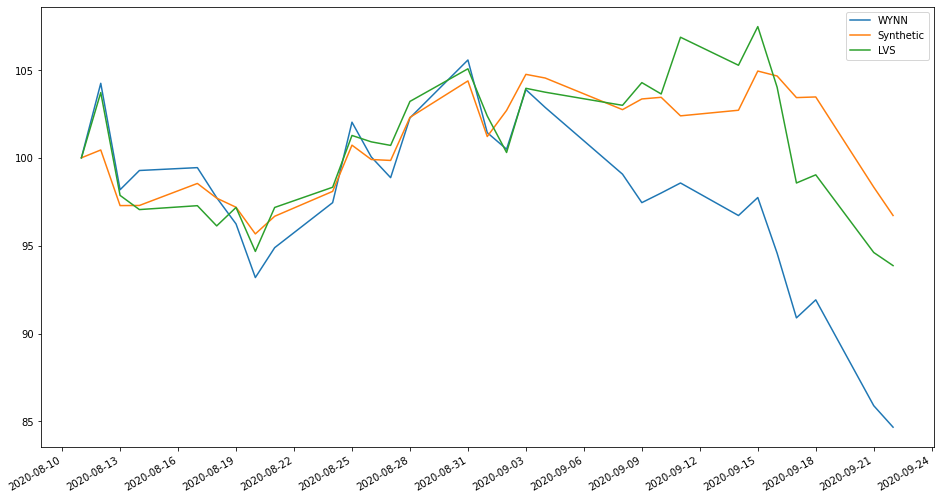

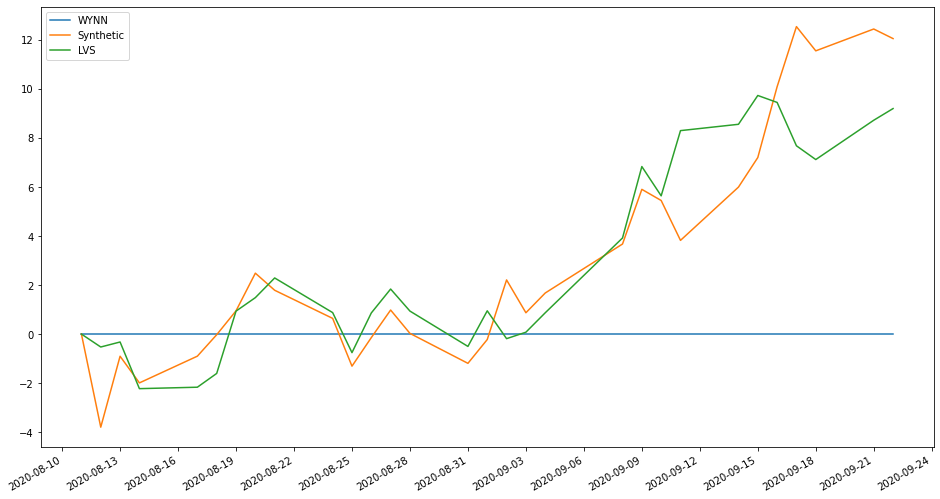

{'Correlation': {'WYNNxSynthetic': 0.8524092356268572,
  'WYNNxLVS': 0.8737383594199268},
 'MSE': {'WYNN': 0.0,
  'Synthetic': 30.51434037386548,
  'LVS': 23.958905860569278,
  'CORR': 23.958905860569278},
 'MSE_percent': {'WYNN': 0.0,
  'Synthetic': 2.9701421653554356,
  'LVS': 2.095128967907653}}

In [29]:
# def simulate_stock(stock: {__eq__},
#                    sim_start_date: Any,
#                    sim_end_date: {__sub__},
#                    tr_end_date: {__sub__},
#                    train_num_days: Any,
#                    num_principal_components: Any,
#                    num_pred_stocks: Any,
#                    sparse: Any) -> None
#                    graph: bool = True) -> None
#simulate_stock('AAPL', test_start_date, test_start_date + 20, train_end_date, 120, 2, 10, False, graph = True)

# i=0
# hyperparameters = {}
# low_mse = 10000000
# corr_mse = 0
# for n_principal_components in range(1, 10):
#     for num_train_days in [0, 30, 60, 90, 150, 180, 360]:
#         for n_pred_stocks in [2, 3, 5, 10, 15, 25, 50, 100]:
#             if n_principal_components>=n_pred_stocks:
#                 continue
#             for sparse in [True, False]:
#                 mses = []
#                 corr_mses = []
#                 for r in range(0, 100): # repeats a simulation 100 times to get an average measure of the MSE for these hyperparameters over different stocks and time periods
#                     # tr_end_date should within [train_start_date+num_train_days, train_end_date-num_validation_days] to ensure it does not leak into the test set, even after it is validated
#                     tr_end_date = random.randint(train_start_date+num_train_days, train_end_date - num_validation_days)
#
#                     # validation starts on the soonest day after training is done
#                     validation_start_date = tr_end_date+1
#
#                     num = random.randint(0, len(all_tickers)-1)
#                     stock_to_sim = list(all_tickers)[num]
#
#                     if num_train_days==0:
#                         num_train_days = tr_end_date-1
#
#                     stats = simulate_stock(stock_to_sim, validation_start_date, validation_start_date+num_validation_days, tr_end_date, num_train_days, n_principal_components, n_pred_stocks, sparse, graph=False)
#                     mses.append(stats['MSE']['Synthetic'])
#                     corr_mses.append(stats['MSE']["CORR"])
#
#                 print(i)
#                 i+=1
#
#                 avg_mse = sum(mses)/100
#                 avg_corr_mse = sum(corr_mses)/100
#
#                 if avg_mse<=low_mse:
#                     low_mse = avg_mse
#                     corr_mse = avg_corr_mse
#                     hyperparameters = {'npca': n_principal_components, 'ntd': num_train_days, 'nps': n_pred_stocks, 'sparse': sparse}
# print(low_mse)
# print(corr_mse)
# print(hyperparameters)

#0.0001232489645044427
#{'npca': 2, 'ntd': 30, 'nps': 3, 'sparse': True}
# simulate_stock('COST', test_start_date, test_start_date + 20, train_end_date, 30, 2, 3, True, graph = True)

# 0.010779939104229553
# {'npca': 4, 'ntd': 30, 'nps': 5, 'sparse': False}
# simulate_stock("COST", test_start_date, test_start_date+30, train_end_date, 30, 4, 5, True, graph=True)

# 46.56410051362909
# {'npca': 4, 'ntd': 30, 'nps': 25, 'sparse': False}

# 47.28842525584654
# {'npca': 7, 'ntd': 90, 'nps': 25, 'sparse': True}

# 36.120000133501776
# {'npca': 1, 'ntd': 150, 'nps': 15, 'sparse': False}


# 22.05078125720328
# {'npca': 3, 'ntd': 360, 'nps': 5, 'sparse': False}

# 29.38596396938674
# 53.247185633481195
# {'npca': 1, 'ntd': 90, 'nps': 15, 'sparse': False}

num = random.randint(0, len(all_tickers)-1)
stock_to_sim = list(all_tickers)[num]
simulate_stock(stock_to_sim, test_start_date, test_start_date+30, train_end_date, 90, 2, 15, False, graph=True)

In [13]:
##pf.create_returns_tear_sheet(returns)